### Loading Dataset

In [1]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(source("tree_term_climb.R"))
suppressPackageStartupMessages(library(beaveR))
suppressPackageStartupMessages(library(TreeSummarizedExperiment))
suppressPackageStartupMessages(library(SummarizedExperiment))

saveDir <- "environment/real_datasets/GSE100505_EDL_MAST/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/DE"
load(file.path(saveDir, "tseConsUp.RData"))
load(file.path(saveDir, "bSwishCons_OL.RData"))
treeCons <- rowTree(tseConsUp)
l <- length(treeCons$tip)

In [2]:
metaData <- read.delim("/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/SRR_Acc_List.txt")
quantDir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/sal_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100"
samples <- metaData$RUN
files <- file.path(quantDir, samples, "quant.sf")
colData <- cbind(data.frame(files = files, names = samples), condition = as.factor(metaData$TissueName))
seMuscle <- tximeta::tximeta(colData)

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


found matching transcriptome:
[ GENCODE - Mus musculus - release M25 ]

loading existing TxDb created: 2023-02-17 18:26:37

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

loading existing transcript ranges created: 2023-02-17 18:26:39

fetching genome info for GENCODE



In [12]:
y <- fishpond::scaleInfReps(tseConsUp[1:l,])
y <- labelKeep(y)
set.seed(10)
y <- swish(y, x="condition")

In [2]:
yAll <- computeSizeFactors(tseConsUp)
yAll <- scaleInfReps(yAll)
yAll <- labelKeep(yAll)
set.seed(10)
yInn <- swish(yAll[(l+1):nrow(yAll),], x="condition")

Setting inf rep depth to mean depth



Progress:   1 on 100Progress:   2 on 100Progress:   3 on 100Progress:   4 on 100Progress:   5 on 100Progress:   6 on 100Progress:   7 on 100Progress:   8 on 100Progress:   9 on 100Progress:  10 on 100Progress:  11 on 100Progress:  12 on 100Progress:  13 on 100Progress:  14 on 100Progress:  15 on 100Progress:  16 on 100Progress:  17 on 100Progress:  18 on 100Progress:  19 on 100Progress:  20 on 100Progress:  21 on 100Progress:  22 on 100Progress:  23 on 100Progress:  24 on 100Progress:  25 on 100Progress:  26 on 100Progress:  27 on 100Progress:  28 on 100Progress:  29 on 100Progress:  30 on 100Progress:  31 on 100Progress:  32 on 100Progress:  33 on 100Progress:  34 on 100Progress:  35 on 100Progress:  36 on 100Progress:  37 on 100Progress:  38 on 100Progress:  39 on 100Progress:  40 on 100Progress:  41 on 100Progress:  42 on 100Progress:  43 on 100Progress:  44 on 100Progress:  45 on 100Progress:  46 on 100Progress:  47 on 100Progress:  48 on 100Progress:  49 on 100Progress:  50 on 100

In [3]:
infRepInds <- grep("infRep", assayNames(yAll))
infReps <- assays(yAll)[infRepInds]
infReps <- abind::abind(as.list(infReps), along = 3)
mcols(yAll)[["log2FC"]] <- fishpond:::getLog2FC(infReps, colData(yAll)[["condition"]])

In [4]:
load("treeDE_Paper_Images/mousemuscle/detNodes.RData")
load("treeDE_Paper_Images/mousemuscle/treeDECommonInds.RData")

#### Annotation for plot gardener

In [5]:
library(org.Mm.eg.db)
library(TxDb.Mmusculus.UCSC.mm10.knownGene) ## this one corresponds to the version we need
suppressPackageStartupMessages(library(plyranges))
suppressPackageStartupMessages(library(ggtree))
suppressPackageStartupMessages(library("grid"))
suppressPackageStartupMessages(library("ggplotify"))
suppressPackageStartupMessages(library("ggplot2"))
suppressPackageStartupMessages(library("ggpubr"))

txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
txpMouse <- transcripts(txdb)

txpMouse <- txpMouse %>%
  mutate(tx_id = as.character(tx_id))

txpMouse <- txpMouse %>%
  mutate(gene_id = mapIds(
           txdb, keys=tx_id,
           column="GENEID", keytype="TXID")
         ) %>%
  filter(!is.na(gene_id))
txpMouse <- txpMouse %>%
  mutate(ensID = mapIds(
           org.Mm.eg.db, keys=gene_id,
           column="ENSEMBL", keytype="ENTREZID")
         ) %>%
  filter(!is.na(ensID))
txpMouse <- txpMouse %>%
                filter(tx_name %in% intersect(treeCons$tip, mcols(txpMouse)[["tx_name"]]))

Loading required package: AnnotationDbi



Loading required package: GenomicFeatures

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



In [6]:
genesMouse <- genes(txdb)
genesMouse <- genesMouse %>%
  mutate(ensID = mapIds(org.Mm.eg.db, 
                            gene_id, "ENSEMBL", "ENTREZID")) %>% 
    filter(!is.na(ensID))


  66 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.

'select()' returned 1:many mapping between keys and columns



#### Genes belonging to treeDE nodes that intersect with differentially expressed genes but are not covered by transcripts.'
We see many such genes that contain differential nodes but no differentially expressed transcripts. The magnitude of logFC in most cases though decreases from trancript to gene.

In [9]:
treeDE <- detNodes[["treeDEFDR_OL"]]

In [17]:
order(abs(mcols(yAll)[treeDE[[1]][treeDECommonInds[[1]]], "log2FC"]), decreasing=TRUE)

[1]  32 221  16  46 103  27 123 238 283  11 236  48 136  83 186 253 202  17
 [19]  35 174 206  21 205  72 112 154   6 285 137  30 292 239  75  13  44 156
 [37]  12 187 111 271 155 158 135  18  31 288  73 268 114  81 139 207 287 192
 [55] 214 212 191 246 242 184 275  39 105 286 262  40 138 297  90 177  77 197
 [73] 306 125  24  57  34 126 115 127  41 301  33  97 165 209  28 118  92   7
 [91] 142 148 122  55  60 164  62 284 109  38 294 120  29  36 291  23  47 117
[109] 215 107 225 258 180 129 106 200  82 203 255 300 247 250 163 210 245 220
[127]  51  88 144   1 199 150 116  85  59  10 102 219  94 304 252 182 185 128
[145] 196 298 113 226  65 166   2 267 208 282 167 289 279 218 302  86  53  15
[163]   3 278 100  95  52 243 290 229 266 303 160 259 146 233 131 307  20  54
[181] 256 193 188 261 153  49  98 228 211  70 169 232  87  19  99 172 101  64
[199]  63 235 270 305  76  45 265 201 161  66 183 134 224  67 104  22 295 263
[217] 230   8 222 195 152 124 281 299 254  25 175 130 249 231  80  78  61 151
[235]  42 149 216 204 143 119 198 251 272 145  96 280  14 159  89  43 276 237
[253]   5  50  69 176   9 227 309 173 179 240 248 241  79  56 244 277 181 269
[271]  91 257  93 133 273  74 168 194 234 296 162 293 170  26 264  68 260 147
[289] 171 141 189 157 190 110 108 308 217 121  37  58  71  84 140 213 274 178
[307]   4 132 223

In [7]:
### This function returns the useful elements needed for plot construction, if things can be automated, otherwise we shall start from scratch
#' @ tse - TreeSummarizedExperiment
#' @ tL - tree list
#' @ indlist - for the index set
#' @ gM - for the index set
#' @ i - FDR ind
#' @ j - node index in the index set
extPreInf <- function(tse, y, tL, indList, txpM, gM, i, j) {
    tree <- rowTree(tse)
    iNode <- tL[[i]][indList[[i]][[j]]]
    txShow <- rownames(tse)[Descendants(tree,iNode)[[1]]]
    print(txShow)
    anc <- Ancestors(tree, iNode)
    anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
    treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)
    
    gs <- txpM %>% 
        filter(tx_name %in% treeSub$tip) %>%
        tibble::as_tibble() %>%
        select(ensID) %>%
        unlist %>%
        unique
    print(paste("Genes", gs))
    
    gTxps <- txpM %>% 
        filter(ensID == gs[1]) %>%
        tibble::as_tibble() %>%
        select(tx_name) %>%
        unlist
    
    g <- gM %>% 
        filter(ensID == gs[1]) %>%
        tibble::as_tibble()

    print(gTxps)
    print(treeSub$tip)
    print(all(treeSub$tip %in% gTxps))
    print(all(gTxps %in% treeSub$tip))
    txpMin <- gTxps[which.min(mcols(y)[gTxps, "pvalue"])]
    
    if(length(txpMin)==0) {
        txpMin <- gTxps[which.max(abs(mcols(y)[gTxps, "log10mean"]))]
    }
    minTSInd <- match(txpMin, treeSub$tip)
    return(list(tSub=treeSub, txpMin=txpMin, txShow=txShow, minTInd=minTSInd, iNode=iNode, g=g))
}

### This function plots the infRep plot
plotIReps <- function(y, txpMin, iNode, lp="right") {
    legPos = ifelse(lp=="right", "topright", "topleft")
    cex=1.6
    pTxp <- as.grob(function() plotInfReps(y, txpMin, x = "condition", legend=TRUE,
                              main=txpMin, legendTitle=TRUE, legendCex=cex,
                             legendPos = legPos))
    pInn <- as.grob(function() plotInfReps(y, iNode, x = "condition", legend=TRUE,
                              main="trenDi Candidate Node", legendTitle=TRUE, legendCex=cex,
                             legendPos = legPos))
    return(list(pTxp, pInn))    
}

plotTree <- function(treeSub, iNode, txNode, of=20.5, ofex=4, xlim=NA) {
    xx <- ifelse(is.na(xlim), 80, xlim)
    pTree <- ggtree(treeSub) + #ggtitle("Tree representing the transcripts covered by gene ENSMUSG00000070509") +
        xlim(NA, xx) +
        geom_tiplab(size=5.5, hjust=-0.1) +
        geom_point2(aes(subset=(node==iNode), color="red"), 
                size=5, fill='red', show.legend=T) +
        geom_point2(aes(subset=(node==txNode), color = "black"), 
                size=5, fill='black', show.legend=T) +
        geom_cladelab(node = iNode, label = "", textcolour="red", barsize=2,
                      barcolour="red",  fontsize=5, offset = of) + 
        geom_cladelab(node = txNode, label = "", textcolour="black",
                      fontsize=5, offset = of+ofex) +
        theme(legend.position = "bottom", legend.text=element_text(size=18),
             plot.title=element_text(size=18, face="bold", hjust=0.5)) +
        scale_color_manual(name = "", labels=c("Transcript with the lowest pvalue", "Candidate node"),
               values=c("black", "red"))
    return(pTree)
}

parF <- function(g, txShow, treeSub, chromSt=100, chromEnd=200, fs=14) {
    par <- plotgardener::pgParams(
          chrom = as.character(g[["seqnames"]]), 
          chromstart = g[["start"]]-chromSt, chromend = g[["end"]]+chromEnd,
          assembly = "mm10", just = c("left", "bottom"), fontsize = fs,
        default.units = "inches"
        )
    
    hilite <- data.frame(transcript=c(txShow, setdiff(treeSub$tip, txShow)), 
                     color=c(rep("red", length(txShow)),
                             rep("blue", length(setdiff(treeSub$tip, txShow)))))
    
    return(list(par, hilite))
}

[1] "ENSMUST00000120135.7" "ENSMUST00000055087.6"
[1] "Genes ENSMUSG00000021457"
              tx_name1               tx_name2               tx_name3 
"ENSMUST00000120135.7" "ENSMUST00000118756.7" "ENSMUST00000150672.1" 
              tx_name4               tx_name5 
"ENSMUST00000055087.6" "ENSMUST00000140339.1" 
[1] "ENSMUST00000120135.7" "ENSMUST00000055087.6" "ENSMUST00000118756.7"
[4] "ENSMUST00000140339.1" "ENSMUST00000150672.1"
[1] TRUE
[1] TRUE



Attaching package: 'plotgardener'


The following object is masked from 'package:base':

    c


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



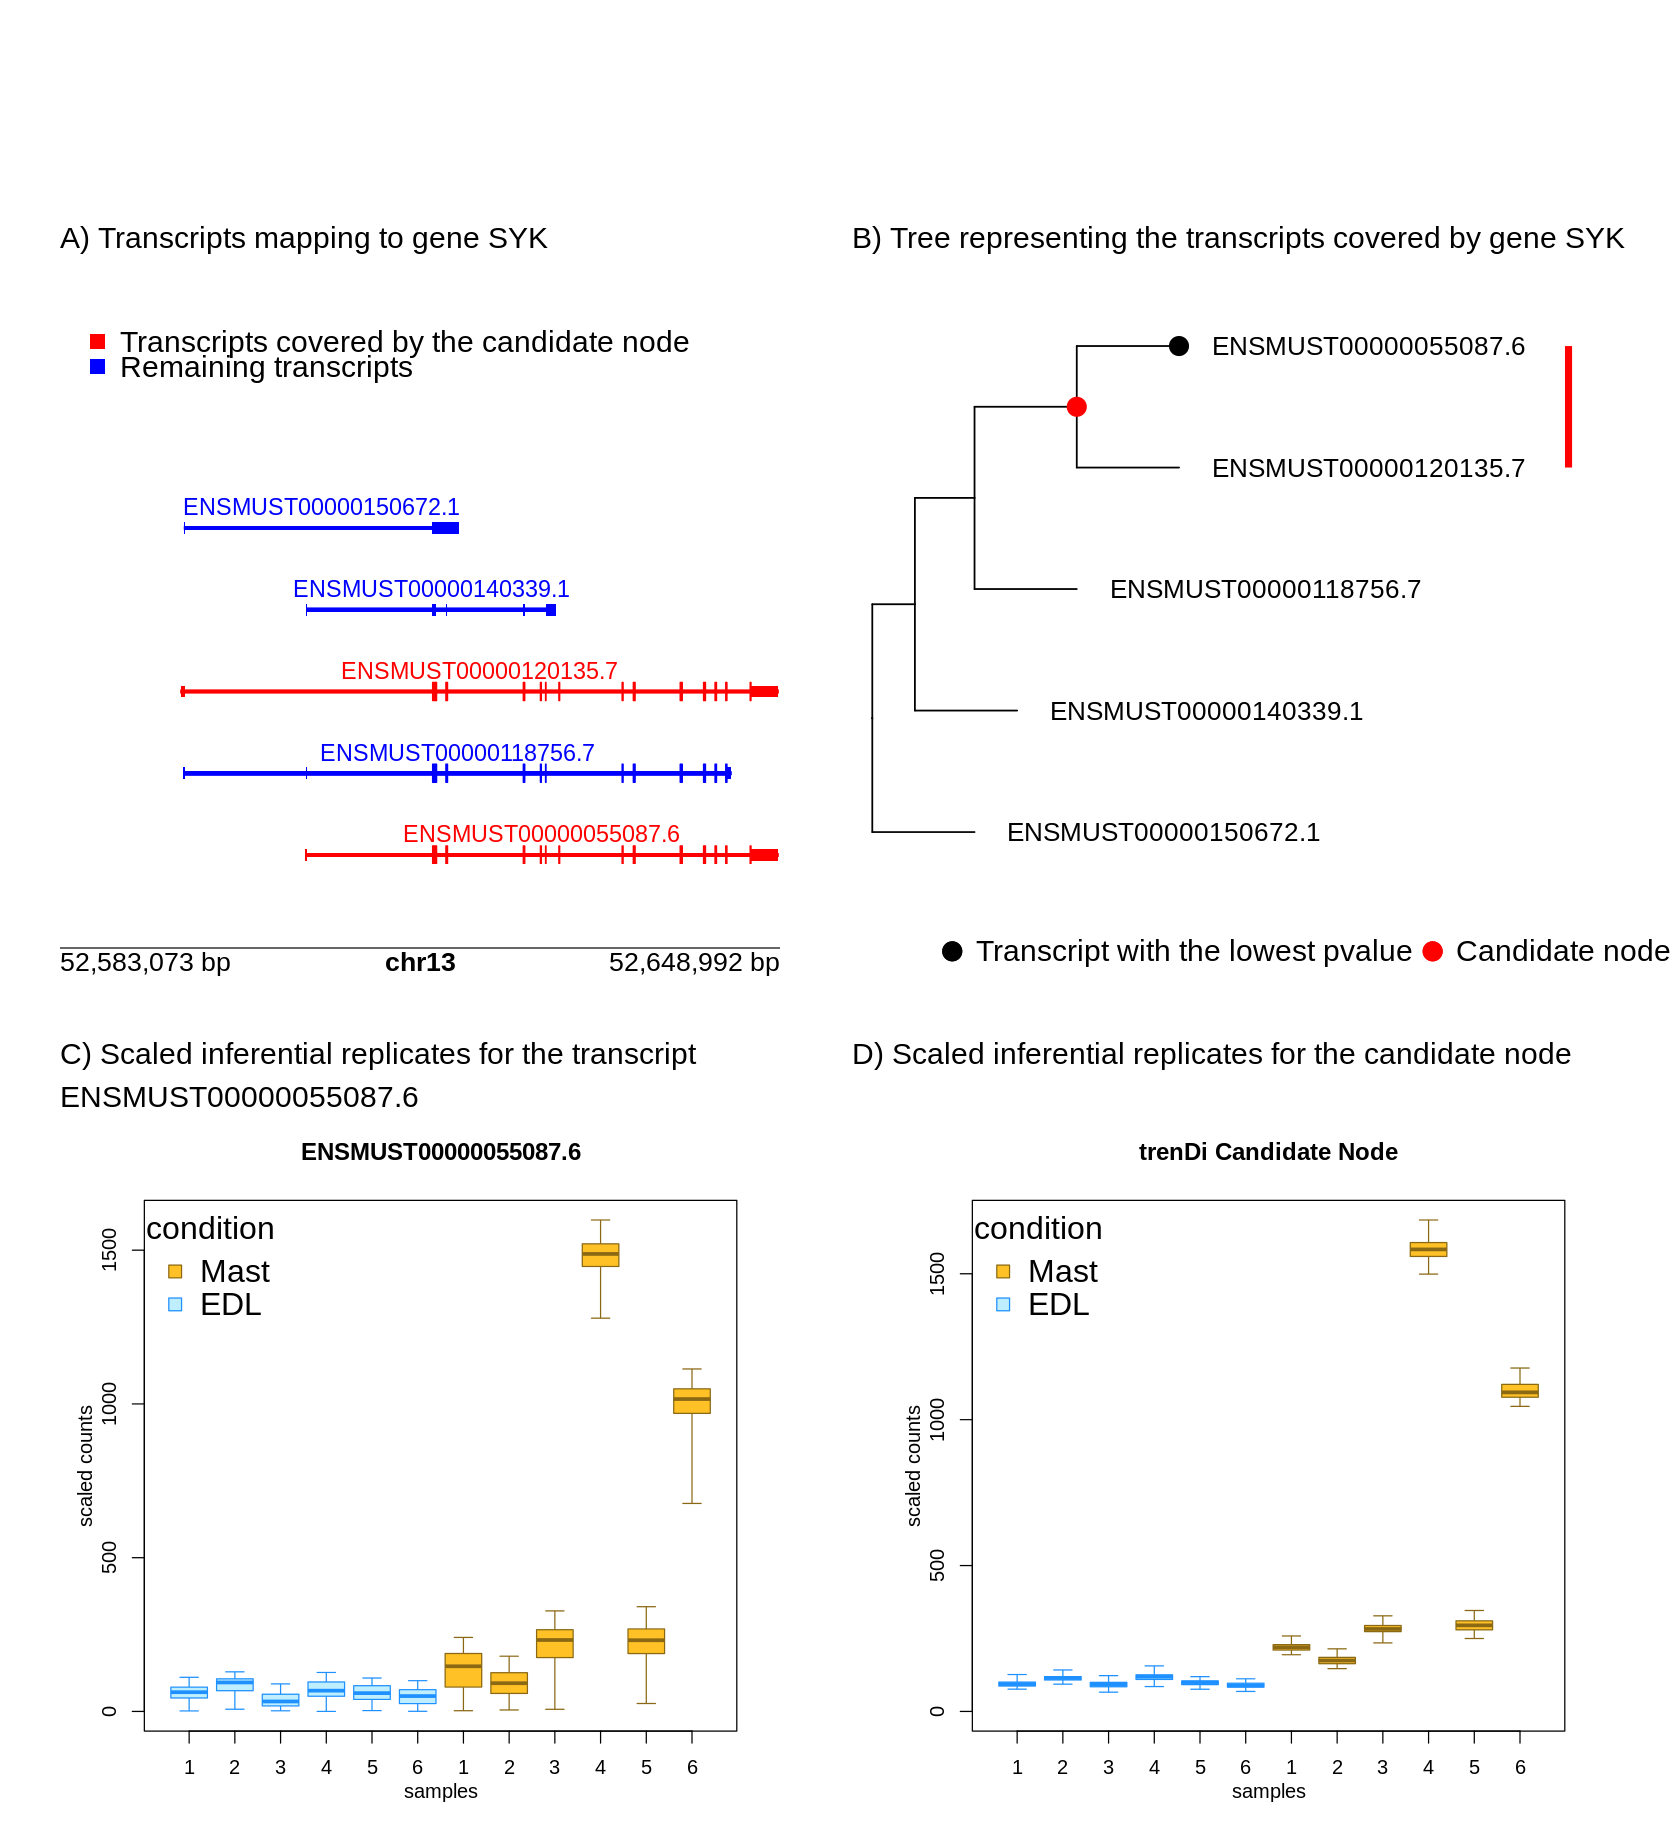

In [13]:
i <- 1
j <- 283
tt <- extPreInf(tseConsUp, y, treeDE, treeDECommonInds, txpMouse, genesMouse, i, j)
pI <- plotIReps(yAll, tt$txpMin, tt$iNode, lp="left")
pTree <- plotTree(tt$tSub, 9, tt$minTInd, of=45, xlim=100)
pgs <- parF(tt$g, tt$txShow, tt$tSub)

options(repr.plot.width=14, repr.plot.height=15.4)
library(plotgardener)
pageCreate(width = 14, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgs[[1]]

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- pgs[[2]]
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 1, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=18,
)
plotText(label="A) Transcripts mapping to gene SYK", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 1.5, y = 5.5, width = 5, height = 8.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotGenomeLabel(
  params = par, x = 0.5, y = 6.2, length=6,
  just = c("left", "top"), fontsize=16
)

plotText(label="B) Tree representing the transcripts covered by gene SYK", 
         x = 7.1, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y =0.5, width = 8, height=6
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST00000055087.6", 
         x = 0.5, y = 7, params = parText)

plotGG(
    plot = pI[[1]],
    x = 0.5, y = 7.6, width = 6, height=6
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.1, y = 7, params = parText)

plotGG(
    plot = pI[[2]],
    x = 7.4, y = 7.6, width = 6, height=6
)

[1] "ENSMUST00000089338.5" "ENSMUST00000171503.7"
[1] "Genes ENSMUSG00000034623"
              tx_name1               tx_name2               tx_name3 
"ENSMUST00000171503.7" "ENSMUST00000089338.5" "ENSMUST00000169113.1" 
[1] "ENSMUST00000089338.5" "ENSMUST00000171503.7" "ENSMUST00000169113.1"
[1] TRUE
[1] TRUE


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



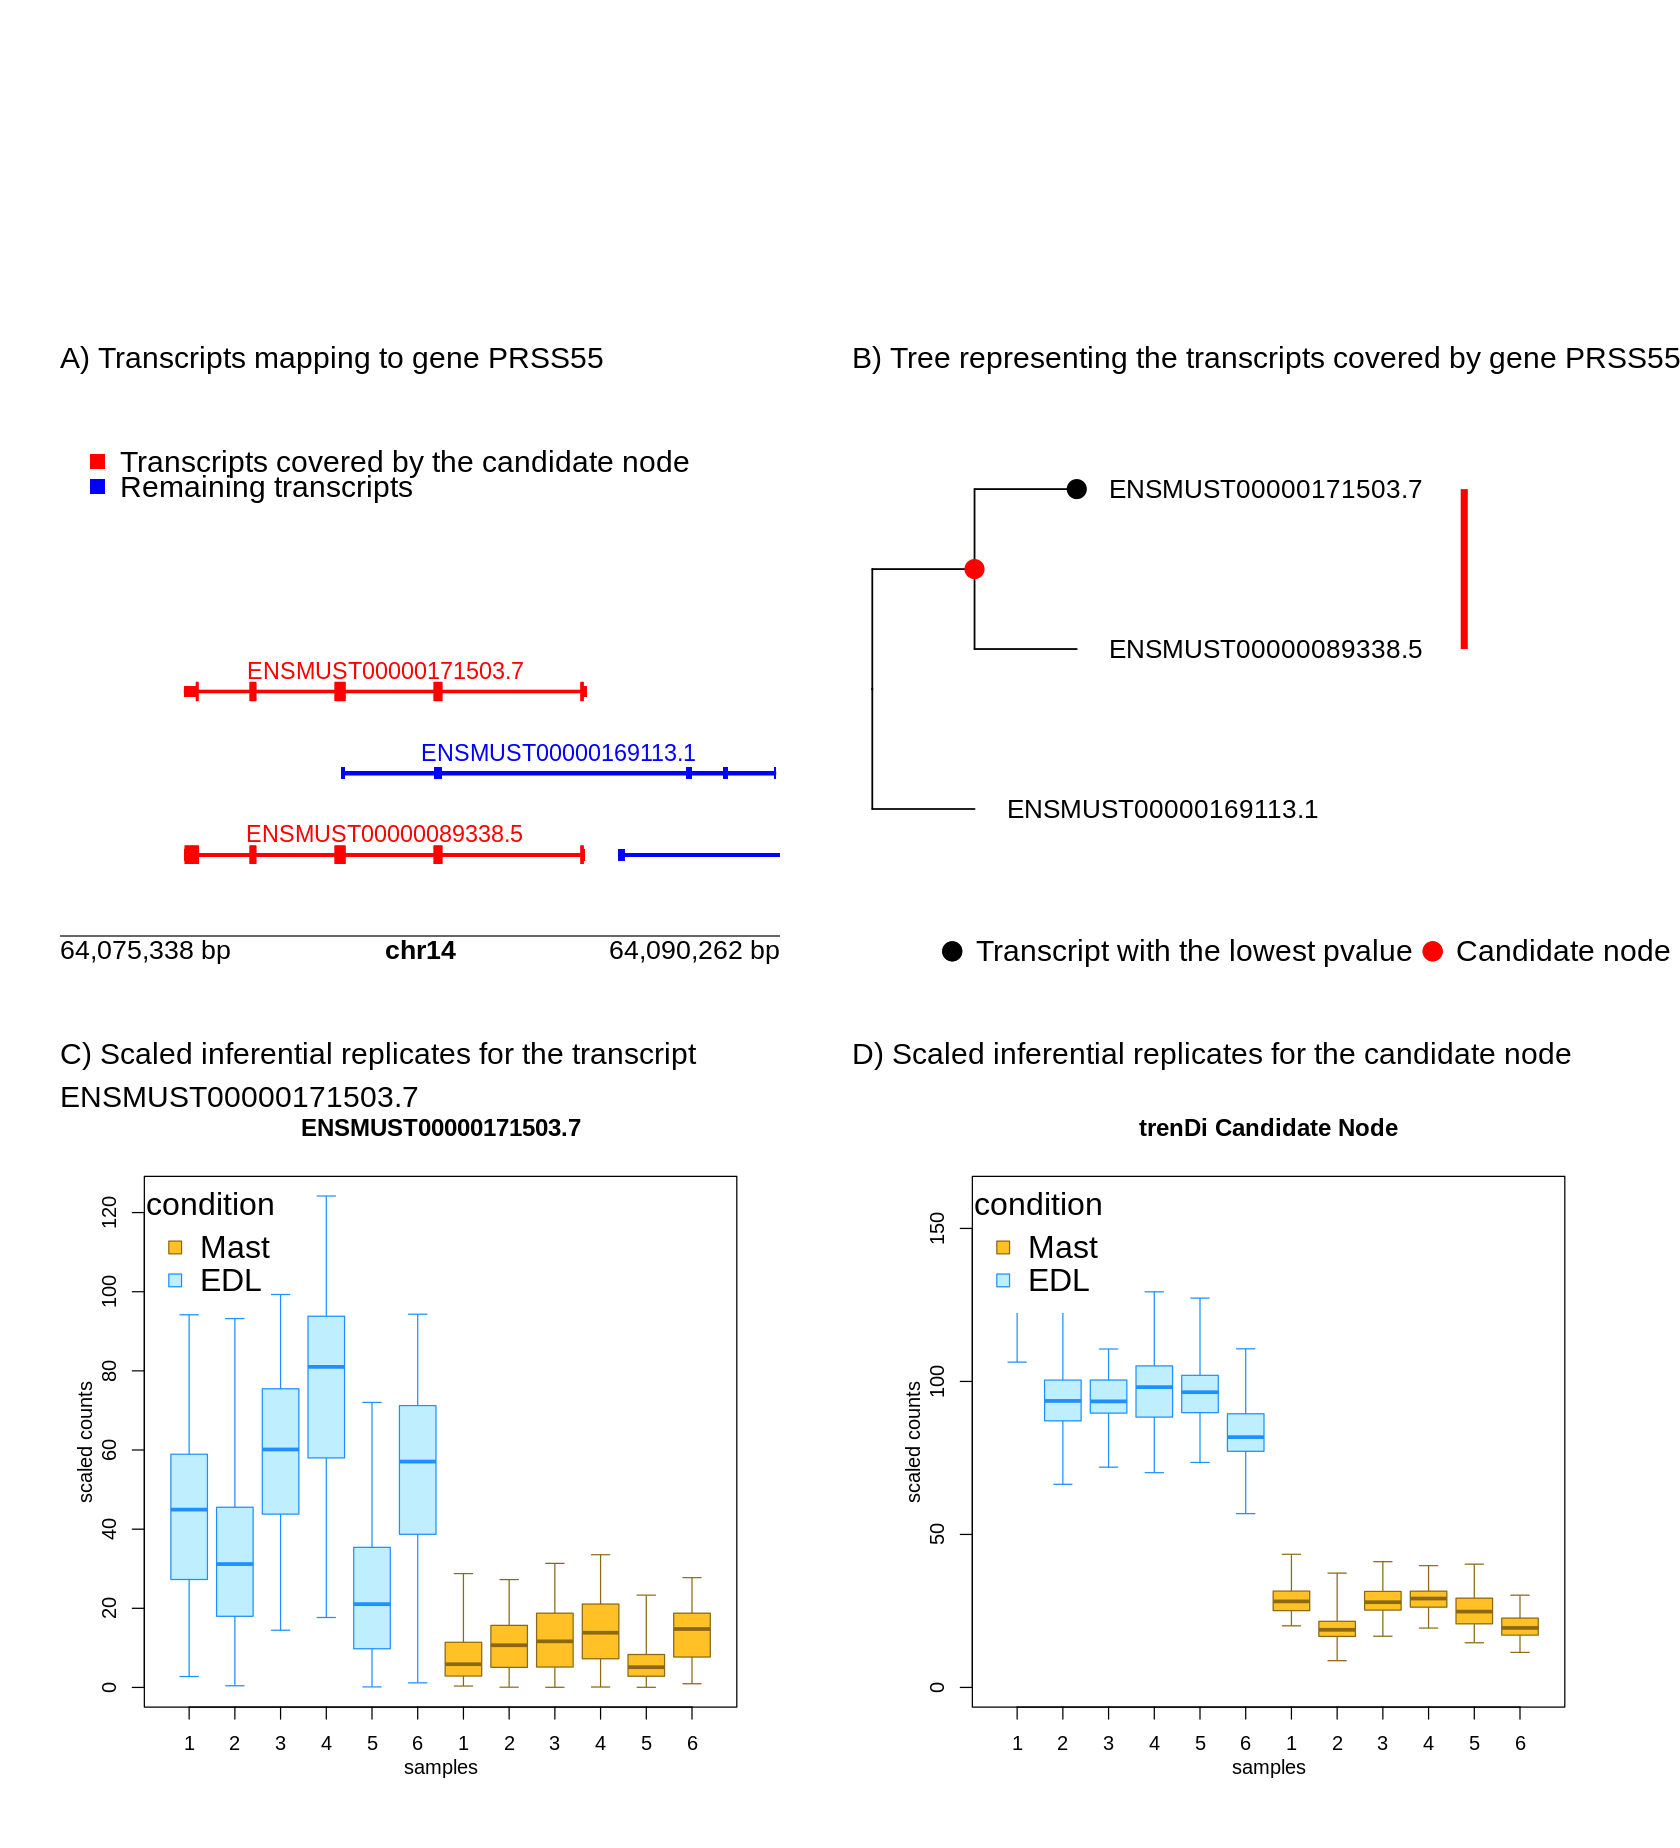

In [14]:
i <- 1
j <- 17
tt <- extPreInf(tseConsUp, y, treeDE, treeDECommonInds, txpMouse, genesMouse, i, j)
pI <- plotIReps(yAll, tt$txpMin, tt$iNode, lp="left")
pTree <- plotTree(tt$tSub, 5, tt$minTInd, of=45, xlim=100)
pgs <- parF(tt$g, tt$txShow, tt$tSub, chromSt = 100, chromEnd = 100,fs=14)

library(plotgardener)
pageCreate(width = 14, height = 10, showGuides = FALSE, default.units = "inches")
par <- pgs[[1]]

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")
parTxp  <- pgParams(
    fontsize = 14,
    fontcolor="blue"
)

hilite <- pgs[[2]]
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 1, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=18,
)
plotText(label="A) Transcripts mapping to gene PRSS55", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 1.5, y = 4.5, width = 5, height = 8.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)


plotGenomeLabel(
  params = par, x = 0.5, y = 5.1, length=6,
  just = c("left", "top"), fontsize=16
)

plotText(label="B) Tree representing the transcripts covered by gene PRSS55", 
         x = 7.1, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y =0.5, width = 8, height=5
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST00000171503.7", 
         x = 0.5, y = 6, params = parText)

plotGG(
    plot = pI[[1]],
    x = 0.5, y = 6.4, width = 6, height=6
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.1, y = 6, params = parText)

plotGG(
    plot = pI[[2]],
    x = 7.4, y = 6.4, width = 6, height=6
)

[1] "ENSMUST00000141294.1" "ENSMUST00000142448.7" "ENSMUST00000138821.7"
[1] "Genes ENSMUSG00000055632"
              tx_name1               tx_name2               tx_name3 
"ENSMUST00000113532.8" "ENSMUST00000226996.1" "ENSMUST00000130375.1" 
              tx_name4               tx_name5               tx_name6 
"ENSMUST00000138821.7" "ENSMUST00000142448.7" "ENSMUST00000141294.1" 
[1] "ENSMUST00000130375.1" "ENSMUST00000226996.1" "ENSMUST00000113532.8"
[4] "ENSMUST00000141294.1" "ENSMUST00000142448.7" "ENSMUST00000138821.7"
[1] TRUE
[1] TRUE


legend[legend1]

text[text1]

transcripts[transcripts1]

text[text2]

text[text2]

text[text2]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



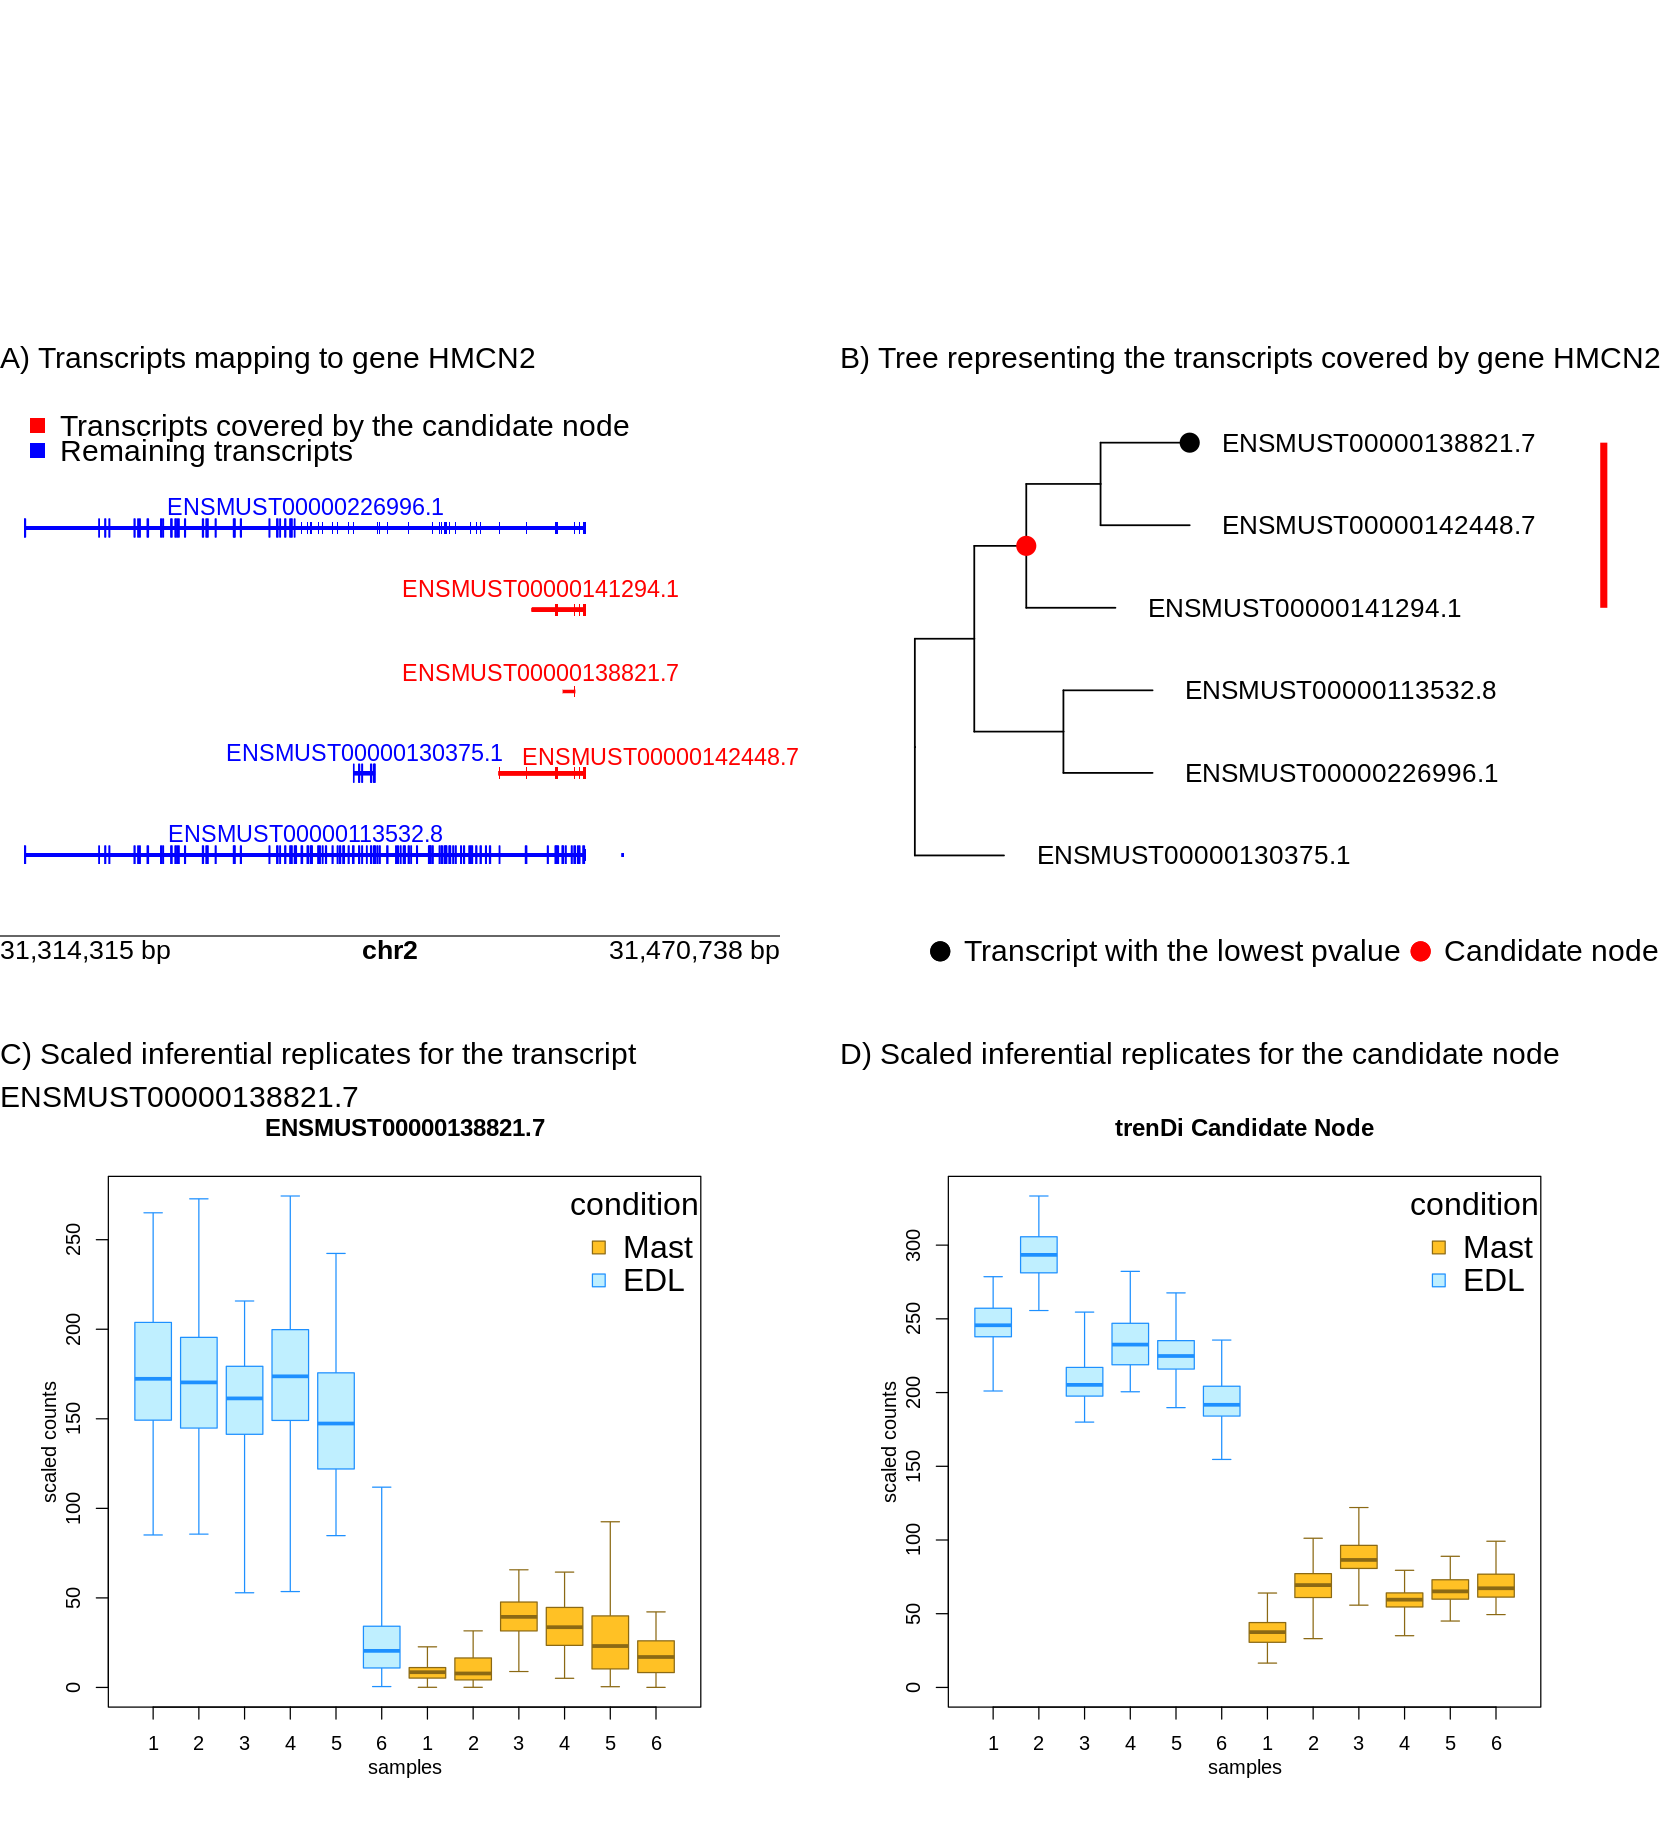

In [15]:
i <- 1
j <- 206
tt <- extPreInf(tseConsUp, y, treeDE, treeDECommonInds, txpMouse, genesMouse, i, j)
pI <- plotIReps(yAll, tt$txpMin, tt$iNode, lp="right")
pTree <- plotTree(tt$tSub, 10, tt$minTInd, of=55, xlim=100)
pgs <- parF(tt$g, tt$txShow, tt$tSub, chromSt = 100, chromEnd = 10000,fs=14)

library(plotgardener)
pageCreate(width = 16, height = 10, showGuides = FALSE, default.units = "inches")
par <- pgs[[1]]

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")
parTxp  <- pgParams(
    fontsize = 14,
    fontcolor="red"
)

hilite <- pgs[[2]]
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 1, y = 0.7, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=18,
)
plotText(label="A) Transcripts mapping to gene HMCN2", x = 1, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 1.2, y = 4.5, width = 5, height = 8.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)
   
plotText(label="ENSMUST00000138821.7", x = 5.5, y = 2.9,
        params = parTxp)
plotText(label="ENSMUST00000142448.7", x = 6.5, y = 3.6,
        params = parTxp)
plotText(label="ENSMUST00000141294.1", x = 5.5, y = 2.2,
        params = parTxp)

plotGenomeLabel(
  params = par, x = 1, y = 5.1, length=6.5,
  just = c("left", "top"), fontsize=16
)

plotText(label="B) Tree representing the transcripts covered by gene HMCN2", 
         x = 8, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 8.2, y =0.5, width = 7, height=5
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST00000138821.7", 
         x = 1, y = 6, params = parText)

plotGG(
    plot = pI[[1]],
    x = 1.2, y = 6.4, width = 6, height=6
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 8, y = 6, params = parText)

plotGG(
    plot = pI[[2]],
    x = 8.2, y = 6.4, width = 6, height=6
)

[1] "ENSMUST00000210192.1"  "ENSMUST00000032927.13" "ENSMUST00000164479.8" 
[4] "ENSMUST00000167888.8" 
[1] "Genes ENSMUSG00000030688"
               tx_name1                tx_name2                tx_name3 
 "ENSMUST00000163799.8"  "ENSMUST00000164479.8" "ENSMUST00000032927.13" 
               tx_name4                tx_name5                tx_name6 
 "ENSMUST00000210192.1"  "ENSMUST00000172630.7"  "ENSMUST00000174291.7" 
               tx_name7                tx_name8                tx_name9 
 "ENSMUST00000167888.8"  "ENSMUST00000173270.7"  "ENSMUST00000174083.1" 
              tx_name10 
 "ENSMUST00000174140.1" 
 [1] "ENSMUST00000210192.1"  "ENSMUST00000032927.13" "ENSMUST00000164479.8" 
 [4] "ENSMUST00000167888.8"  "ENSMUST00000174291.7"  "ENSMUST00000174140.1" 
 [7] "ENSMUST00000173270.7"  "ENSMUST00000172630.7"  "ENSMUST00000163799.8" 
[10] "ENSMUST00000174083.1"  "ENSMUST00000172662.1" 
[1] FALSE
[1] TRUE


legend[legend1]

text[text1]

transcripts[transcripts1]

text[text2]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



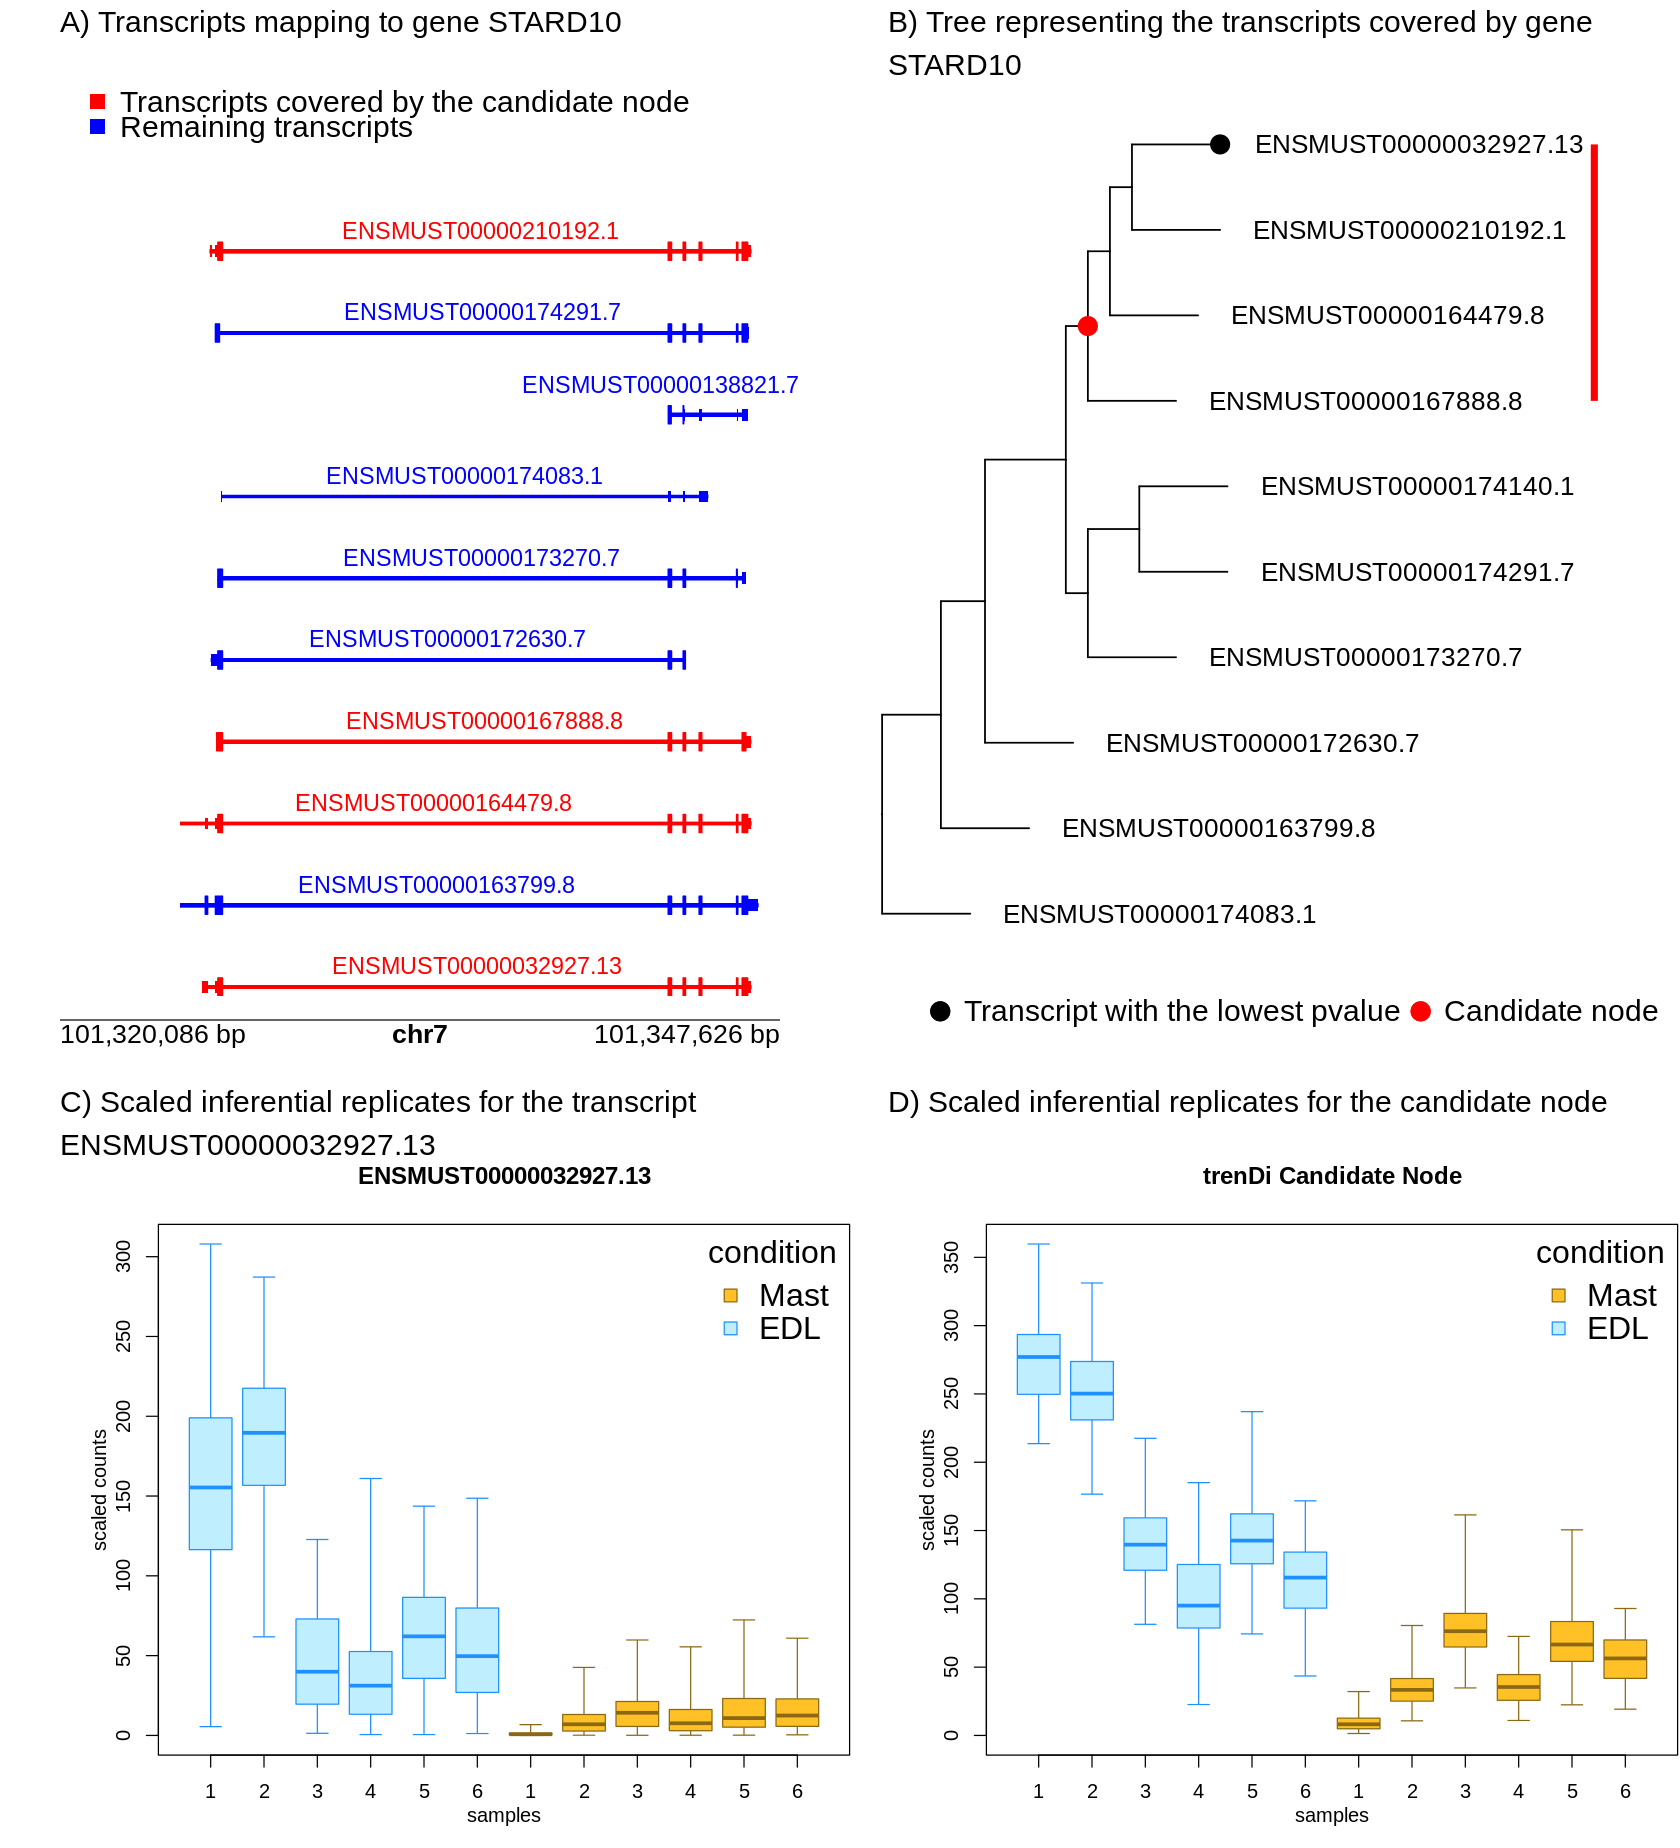

In [16]:
i <- 1
j <- 21
tt <- extPreInf(tseConsUp, y, treeDE, treeDECommonInds, txpMouse, genesMouse, i, j)
tt$tSub <- drop.tip(tt$tSub,
         setdiff(tt$tSub$tip.label, txpMouse %>% 
                 filter(ensID=="ENSMUSG00000030688") %>%
                 data.frame  %>% select(tx_name) %>% unlist))
pI <- plotIReps(yAll, tt$txpMin, tt$iNode, lp="right")
pTree <- plotTree(tt$tSub, 15, tt$minTInd, of=50, xlim=110)
pgs <- parF(tt$g, tt$txShow, tt$tSub, chromSt = -3000, chromEnd=1000,fs=14)
parTxp  <- pgParams(
    fontsize = 14,
    fontcolor="blue"
)

library(plotgardener)
pageCreate(width = 14, height = 16, showGuides = FALSE, default.units = "inches")
par <- pgs[[1]]

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- pgs[[2]]
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 1, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=18,
)
plotText(label="A) Transcripts mapping to gene STARD10", x = 0.5, y = 0.4,
        params = parText)

plotTranscripts(
    params = par, x = 1.5, y = 8.6, width = 5, height = 8, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)

plotText(label="ENSMUST00000138821.7", x = 5.5, y = 3.5,
        params = parTxp)

plotGenomeLabel(
  params = par, x = 0.5, y = 8.8, length=6,
  just = c("left", "top"), fontsize=16
)

plotText(label="B) Tree representing the transcripts covered by gene \nSTARD10", 
         x = 7.4, y = 0.4, params = parText)
plotGG(
    plot = pTree,
    x = 6.9, y =1, width = 7.6, height=8
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST00000032927.13", 
         x = 0.5, y = 9.4, params = parText)

plotGG(
    plot = pI[[1]],
    x = 0.5, y = 9.8, width = 7, height=6
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.4, y = 9.4, params = parText)

plotGG(
    plot = pI[[2]],
    x = 7.4, y = 9.8, width = 7, height=6
)

[1] "ENSMUST00000114025.7" "ENSMUST00000177904.7" "ENSMUST00000114024.8"
[1] "Genes ENSMUSG00000047996"
              tx_name1               tx_name2               tx_name3 
"ENSMUST00000177904.7" "ENSMUST00000114025.7" "ENSMUST00000114024.8" 
              tx_name4               tx_name5               tx_name6 
"ENSMUST00000126209.7" "ENSMUST00000126994.7" "ENSMUST00000156427.1" 
              tx_name7               tx_name8 
"ENSMUST00000134602.7" "ENSMUST00000132852.7" 
[1] "ENSMUST00000134602.7" "ENSMUST00000114025.7" "ENSMUST00000177904.7"
[4] "ENSMUST00000114024.8" "ENSMUST00000126209.7" "ENSMUST00000156427.1"
[7] "ENSMUST00000126994.7" "ENSMUST00000132852.7"
[1] TRUE
[1] TRUE


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



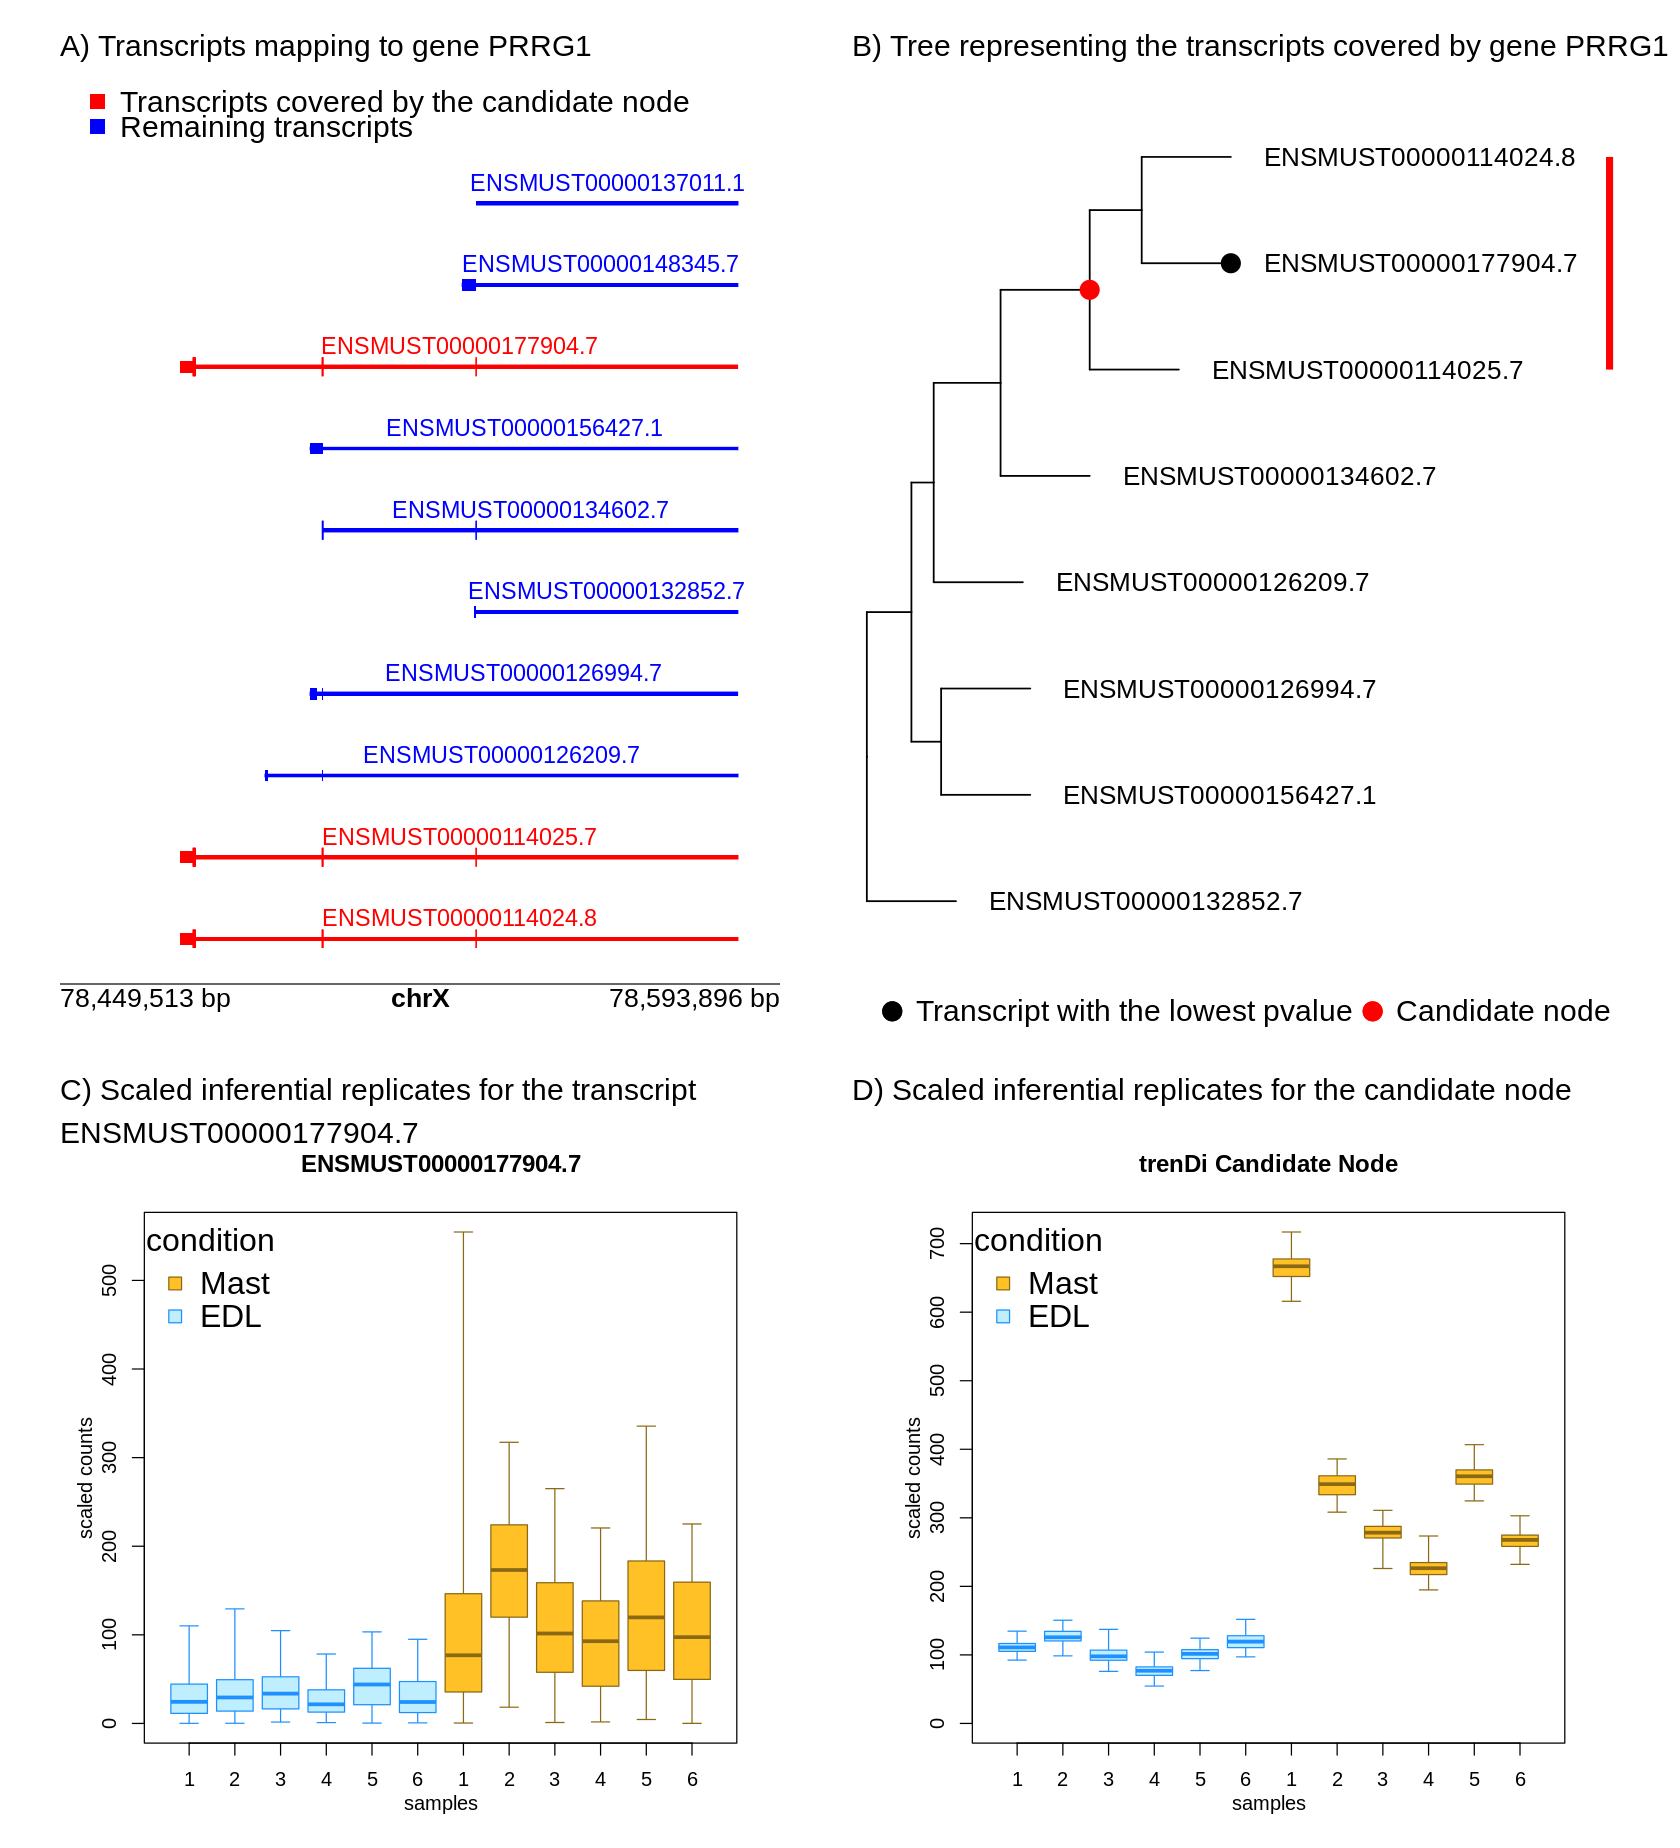

In [17]:
i <- 1
j <- 72
tt <- extPreInf(tseConsUp, y, treeDE, treeDECommonInds, txpMouse, genesMouse, i, j)
pI <- plotIReps(yAll, tt$txpMin, tt$iNode, lp="left")
pTree <- plotTree(tt$tSub, 13, tt$minTInd, of=50, xlim=100)
pgs <- parF(tt$g, tt$txShow, tt$tSub, chromSt = 100, chromEnd = 10000,fs=14)

library(plotgardener)
pageCreate(width = 14, height = 15, showGuides = FALSE, default.units = "inches")
par <- pgs[[1]]

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- pgs[[2]]
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.5, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=18,
)
plotText(label="A) Transcripts mapping to gene PRRG1", x = 0.5, y = 0.1,
        params = parText)

plotTranscripts(
    params = par, x = 1.5, y = 7.7, width = 5, height = 7, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)


plotGenomeLabel(
  params = par, x = 0.5, y = 8, length=6,
  just = c("left", "top"), fontsize=16
)

plotText(label="B) Tree representing the transcripts covered by gene PRRG1", 
         x = 7.1, y = 0.1, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y =0.5, width = 7, height=8
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST00000177904.7", 
         x = 0.5, y = 8.8, params = parText)

plotGG(
    plot = pI[[1]],
    x = 0.5, y = 9.2, width = 6, height=6
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.1, y = 8.8, params = parText)

plotGG(
    plot = pI[[2]],
    x = 7.4, y = 9.2, width = 6, height=6
)

[1] "ENSMUST00000132328.7" "ENSMUST00000151906.7"
[1] "Genes ENSMUSG00000034164"
               tx_name1                tx_name2                tx_name3 
 "ENSMUST00000132328.7" "ENSMUST00000062821.12"  "ENSMUST00000163299.7" 
               tx_name4                tx_name5                tx_name6 
 "ENSMUST00000151906.7"  "ENSMUST00000132196.1"  "ENSMUST00000153308.1" 
               tx_name7                tx_name8 
 "ENSMUST00000156492.1"  "ENSMUST00000138551.1" 
[1] "ENSMUST00000132328.7"  "ENSMUST00000151906.7"  "ENSMUST00000062821.12"
[4] "ENSMUST00000163299.7"  "ENSMUST00000132196.1"  "ENSMUST00000156492.1" 
[7] "ENSMUST00000138551.1"  "ENSMUST00000153308.1" 
[1] TRUE
[1] TRUE


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]

text[text2]

text[text2]



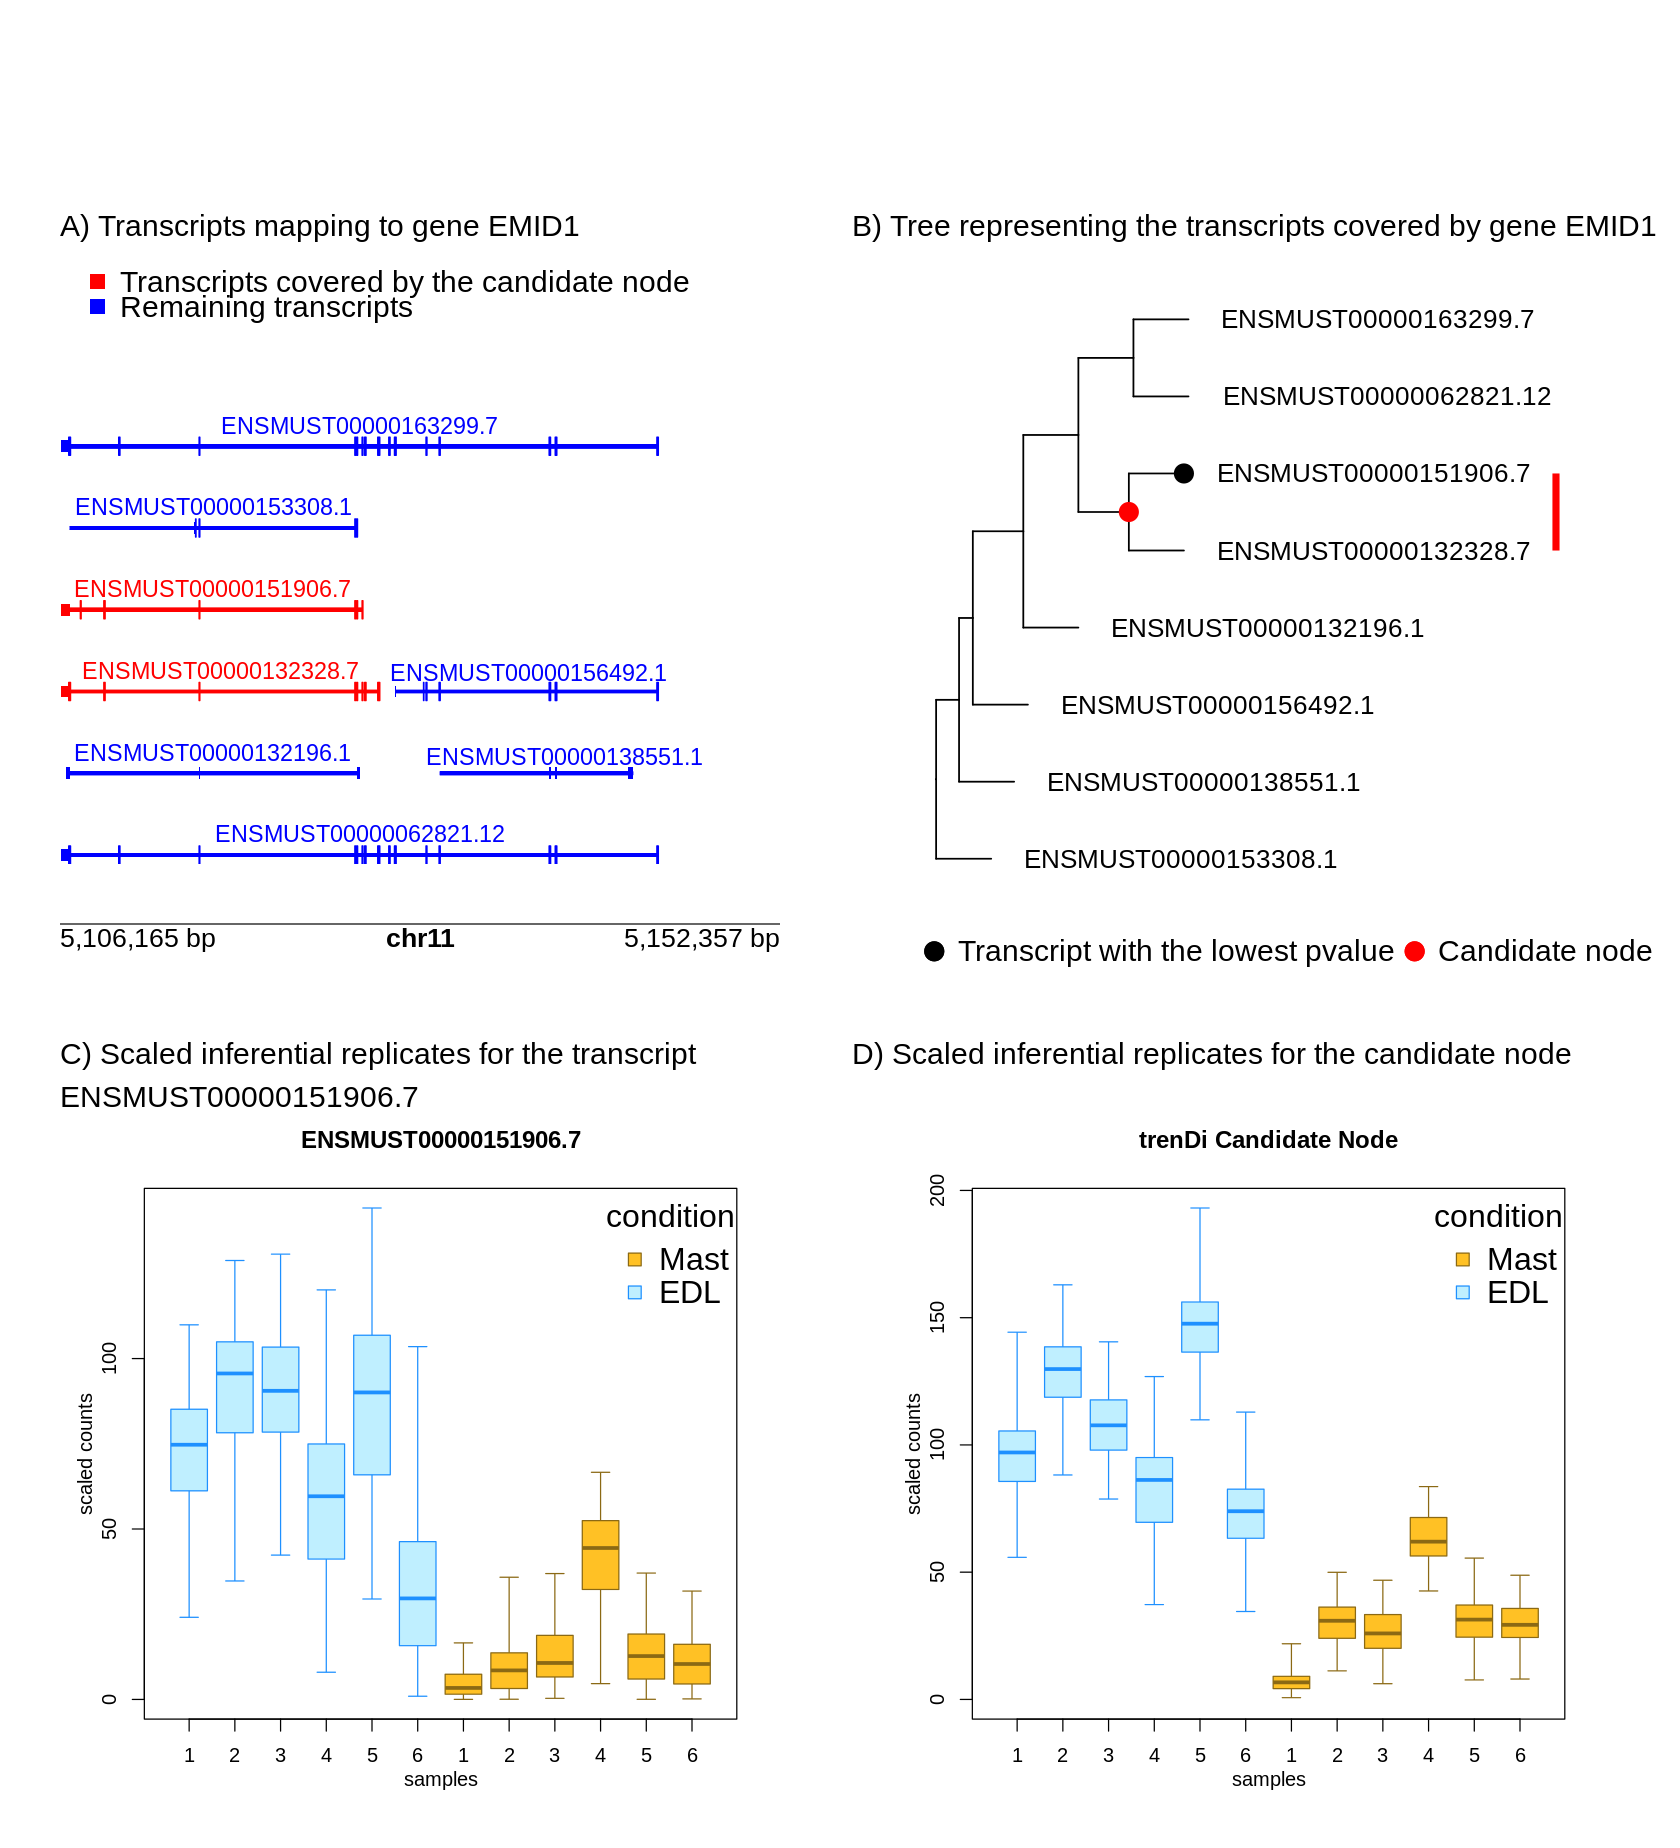

In [18]:
#137
i <- 1
j <- 30
tt <- extPreInf(tseConsUp, y, treeDE, treeDECommonInds, txpMouse, genesMouse, i, j)
pI <- plotIReps(yAll, tt$txpMin, tt$iNode, lp="right")
pTree <- plotTree(tt$tSub, 14, tt$minTInd, of=80, xlim=150)
pgs <- parF(tt$g, tt$txShow, tt$tSub, chromSt = 100, chromEnd = 100,fs=14)

pageCreate(width = 14, height = 12, showGuides = FALSE, default.units = "inches")
par <- pgs[[1]]

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")
parTxp  <- pgParams(
    fontsize = 14,
    fontcolor="blue"
)

hilite <- pgs[[2]]
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.5, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=18,
)
plotText(label="A) Transcripts mapping to gene EMID1", x = 0.5, y = 0.1,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 5.5, width = 5, height = 7.5, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)


plotGenomeLabel(
  params = par, x = 0.5, y = 6, length=6,
  just = c("left", "top"), fontsize=16
)

plotText(label="B) Tree representing the transcripts covered by gene EMID1", 
         x = 7.1, y = 0.1, params = parText)
plotGG(
    plot = pTree,
    x = 7.4, y =0.5, width = 6.5, height=6
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST00000151906.7", 
         x = 0.5, y = 7, params = parText)

plotGG(
    plot = pI[[1]],
    x = 0.5, y = 7.5, width = 6, height=6
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.1, y = 7, params = parText)

plotGG(
    plot = pI[[2]],
    x = 7.4, y = 7.5, width = 6, height=6
)

plotText(label="ENSMUST00000156492.1", x = 4.4, y = 3.9,
        params = parTxp)
plotText(label="ENSMUST00000138551.1", x = 4.7, y = 4.6,
        params = parTxp)

[1] "ENSMUST00000113594.7"  "ENSMUST00000071944.12" "ENSMUST00000073843.12"
[1] "Genes ENSMUSG00000029217"
               tx_name1                tx_name2                tx_name3 
"ENSMUST00000071944.12"  "ENSMUST00000113594.7"  "ENSMUST00000126481.7" 
               tx_name4                tx_name5                tx_name6 
 "ENSMUST00000155342.7" "ENSMUST00000073843.12"  "ENSMUST00000138842.7" 
               tx_name7                tx_name8                tx_name9 
 "ENSMUST00000149533.7"  "ENSMUST00000150193.1"  "ENSMUST00000202547.1" 
[1] "ENSMUST00000138842.7"  "ENSMUST00000155342.7"  "ENSMUST00000113594.7" 
[4] "ENSMUST00000071944.12" "ENSMUST00000073843.12" "ENSMUST00000126481.7" 
[7] "ENSMUST00000149533.7"  "ENSMUST00000202547.1"  "ENSMUST00000150193.1" 
[1] TRUE
[1] TRUE


legend[legend1]

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]

text[text2]

text[text2]



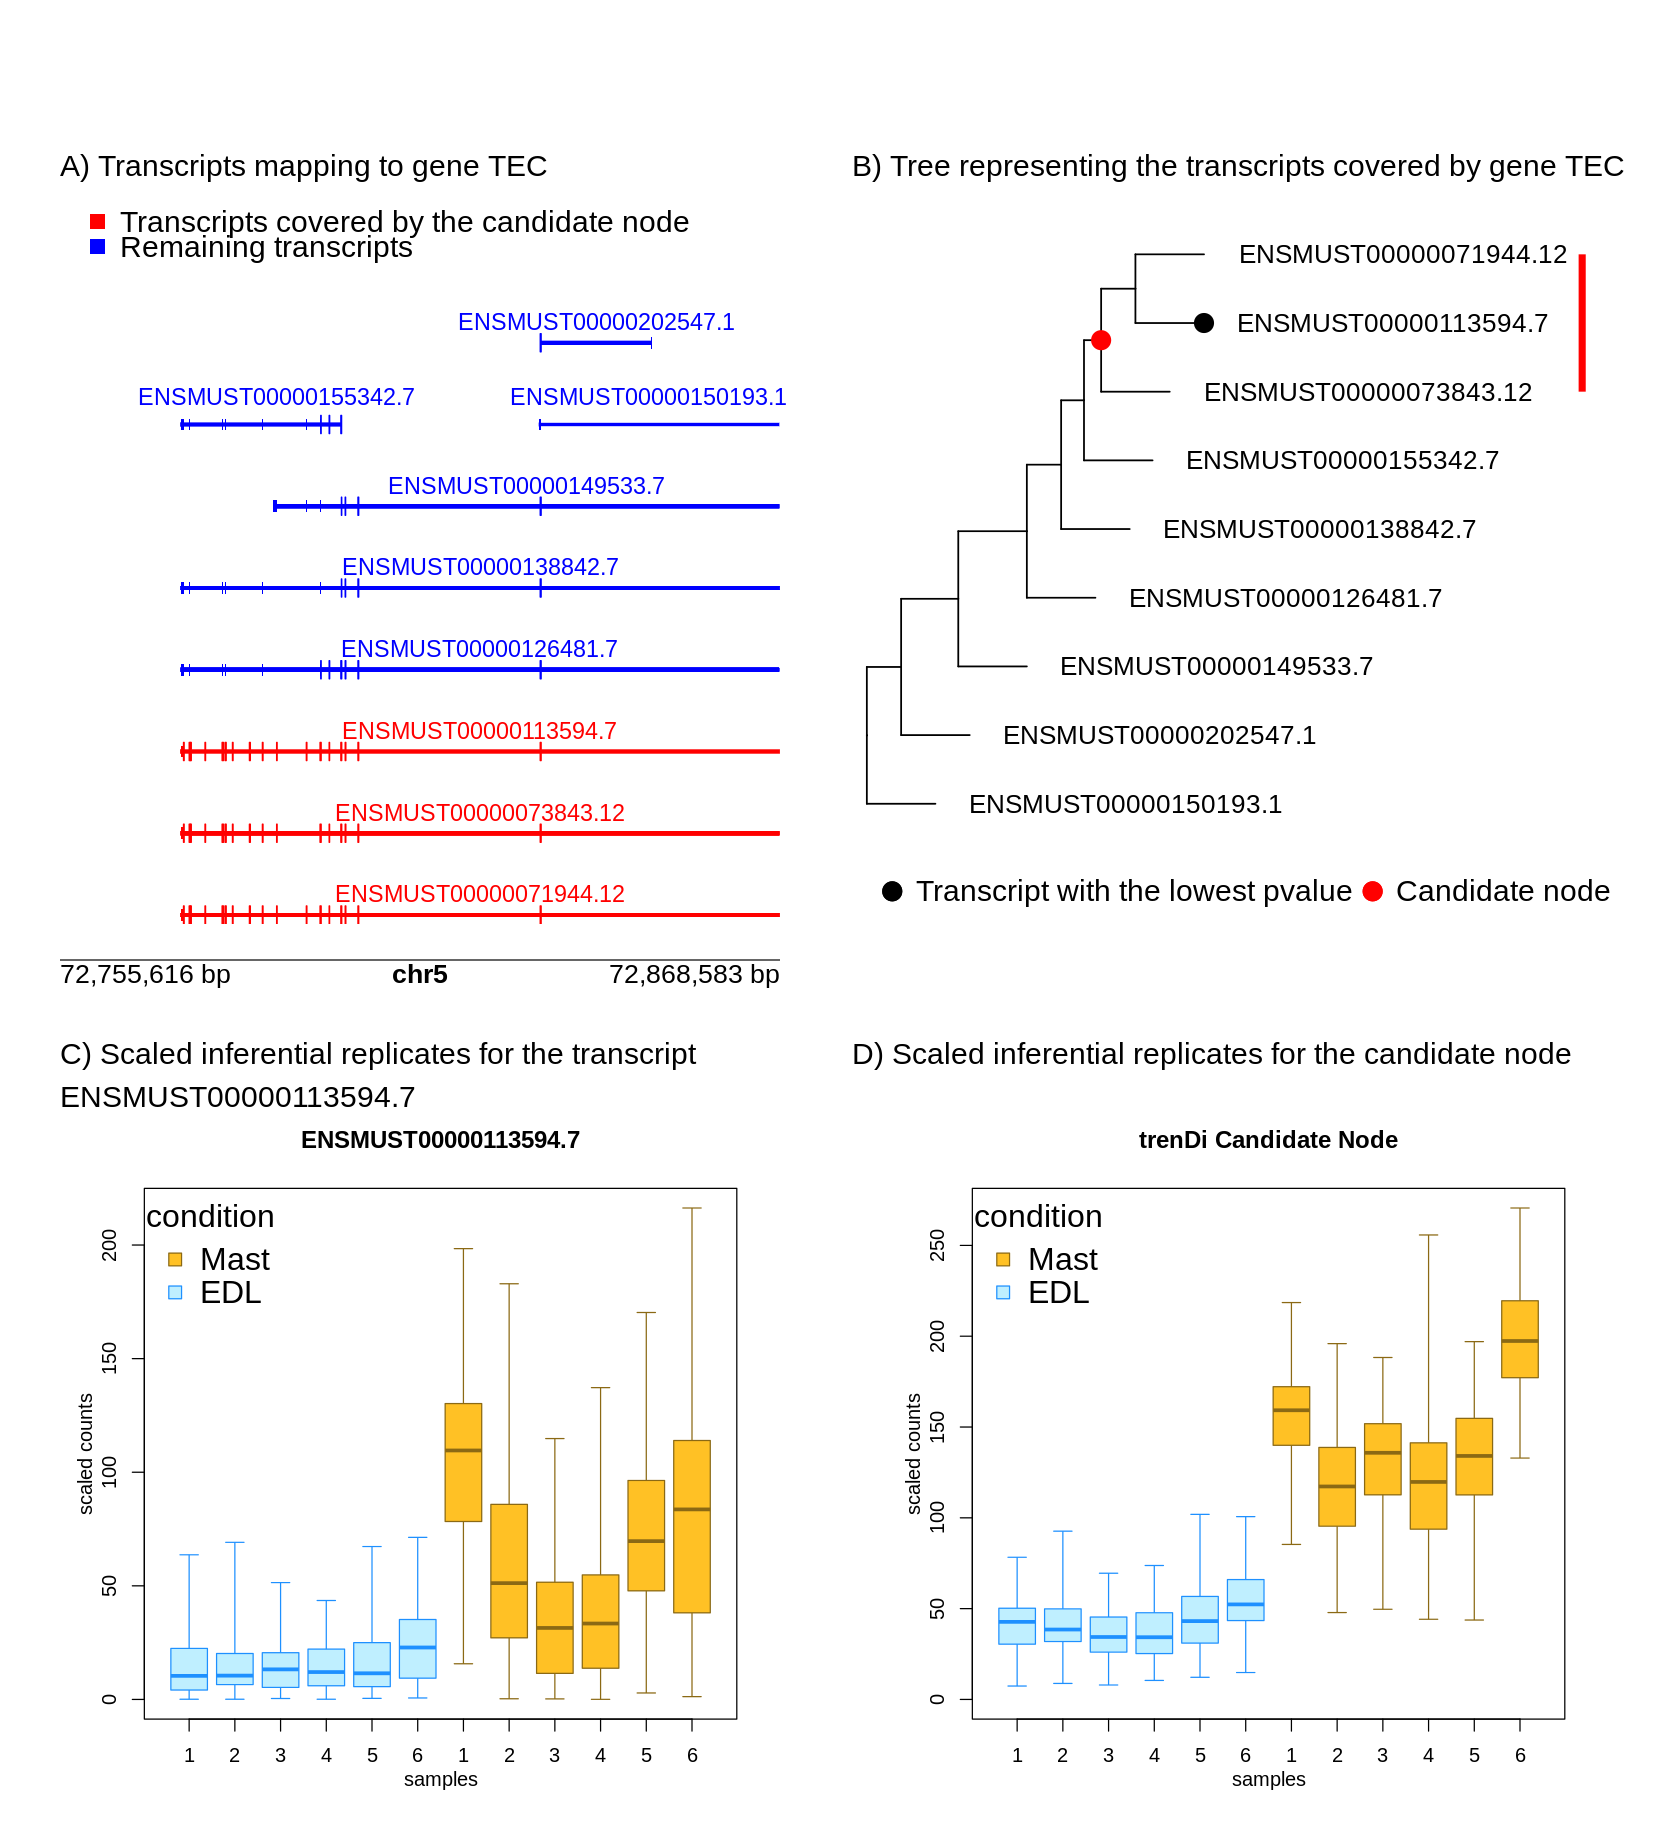

In [19]:
i <- 1
j <- 239
tt <- extPreInf(tseConsUp, y, treeDE, treeDECommonInds, txpMouse, genesMouse, i, j)
pI <- plotIReps(yAll, tt$txpMin, tt$iNode, lp="left")
pTree <- plotTree(tt$tSub, 16, tt$minTInd, of=65, xlim=130)
pgs <- parF(tt$g, tt$txShow, tt$tSub, chromSt = 100, chromEnd = 100,fs=14)

library(plotgardener)
pageCreate(width = 14, height = 13, showGuides = FALSE, default.units = "inches")
par <- pgs[[1]]

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- pgs[[2]]
plotLegend(
    legend = c("Transcripts covered by the candidate node", "Remaining transcripts"),
    fill = c("red", "blue"), border = FALSE,
    x = 0.5, y = 0.5, width = 1, height = 0.5,
    just = c("left", "top"), fontsize=18,
)
plotText(label="A) Transcripts mapping to gene TEC", x = 0.5, y = 0.1,
        params = parText)

plotTranscripts(
    params = par, x = 1.5, y = 6.5, width = 5, height = 7, 
    spaceHeight=2.5, boxHeight=0.15,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)


plotGenomeLabel(
  params = par, x = 0.5, y = 6.8, length=6,
  just = c("left", "top"), fontsize=16
)

plotText(label="B) Tree representing the transcripts covered by gene TEC", 
         x = 7.1, y = 0.1, params = parText)
plotGG(
    plot = pTree,
    x = 6.8, y =0.5, width = 7, height=6
)

plotText(label="C) Scaled inferential replicates for the transcript \nENSMUST00000113594.7", 
         x = 0.5, y = 7.5, params = parText)

plotGG(
    plot = pI[[1]],
    x = 0.5, y = 8, width = 6, height=6
)

plotText(label="D) Scaled inferential replicates for the candidate node", 
         x = 7.1, y = 7.5, params = parText)

plotGG(
    plot = pI[[2]],
    x = 7.4, y = 8, width = 6, height=6
)

plotText(label="ENSMUST00000150193.1" , x = 5.4, y = 2.1,
        params = parTxp)
plotText(label="ENSMUST00000155342.7", x = 2.3, y = 2.1,
        params = parTxp)